# Sistemas Autônomos

## Lista 1

### Distância de Elipses de Confiança

Código para implementação das funções que geram as elipses de confiança e uma amostra de acordo com uma matriz de correlaçães.

Na célula seguinte são apresentados alguns exemplos visando testar as funções implementadas.


In [ ]:
# imports
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from numpy import sin, cos, sqrt, arctan2, pi, array, random, shape
import math

from matplotlib.patches import Arc

np.random.seed(42)

In [ ]:
def get_mahalanobis_level(mean, S, sigma_levels=[1, 2, 3]):

    eigenvalues, eigenvectors = np.linalg.eig(S)

    principal_axis_index = np.argmax(eigenvalues)
    principal_axis = eigenvectors[:, principal_axis_index]

    if principal_axis_index == 0:
      sigma_x, sigma_y = eigenvalues
    else:
      sigma_y, sigma_x = eigenvalues

    angular_coeff = arctan2(principal_axis[1], principal_axis[0]) * 180 / np.pi

    curves = []
    line_patterns = ['r', 'g', 'b', 'r', 'g', 'b']

    for n_sigma in sigma_levels:
      lp =  line_patterns[n_sigma]
      pat = patches.Ellipse(xy=mean,
                            width=2*n_sigma*sigma_x,
                            height=2*n_sigma*sigma_y,
                            angle=angular_coeff,
                            lw=1, edgecolor=lp, fc='None',
                            label=r'${} \sigma$'.format(n_sigma))
      curves.append(pat)

    return curves

def get_correlated_dataset(n, dependency, mu):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    dependent_with_offset = dependent + mu.T
    return dependent_with_offset

def plot_confidence_ellipses(population, curves):
    fig, ax = plt.subplots()

    plt.scatter(population[:,0], population[:,1], marker='.', s=1)
    max_x, max_y = max(population[:,0])+.5, max(population[:,1])+.5
    min_x, min_y = min(population[:,0])-.5, min(population[:,1])-.5

    for curve in curves:
      ax.add_artist(curve)

    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()


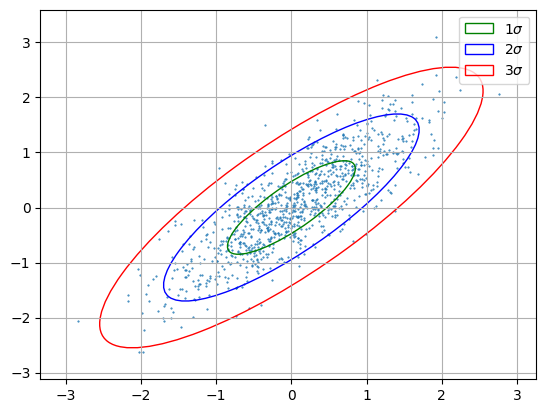

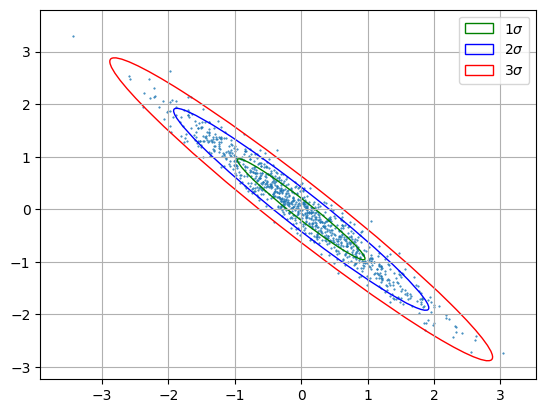

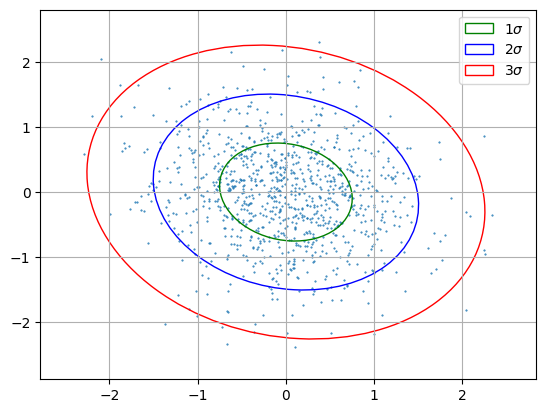

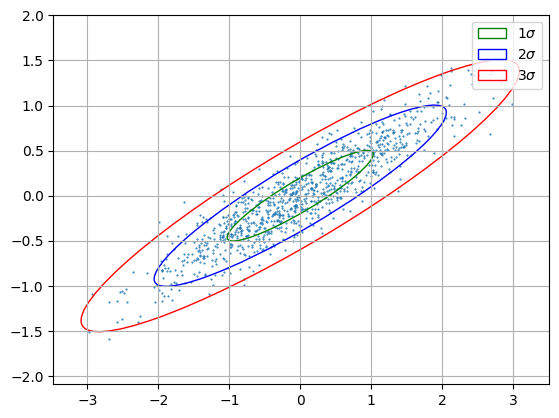

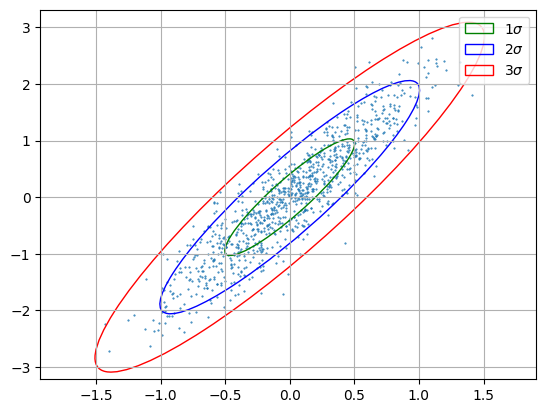

In [ ]:
S = np.array([[2.0, .5], [.5, 0.8]])
mean = np.array([[0], [0]])
levels = [1, 2, 3]

corr_matrixes = [
                  [[0.75, 0.4],
                   [0.4, .75]],        # positive corr
                  [[0.75, -0.6],
                   [-0.6, 0.75]],     #  neg corr
                  [[0.75, -0.05],
                   [-0.05, 0.75]],     #  low corr
                  [[0.9, 0.5],
                   [0.5, 0.05]],     #  low corr
                  [[0.05, 0.5],
                   [0.5, 0.9]]     #  low corr
]

for S in corr_matrixes:

  population = get_correlated_dataset(1000, S, mean)
  curves = get_mahalanobis_level(mean, S, sigma_levels=levels)

  plot_confidence_ellipses(population, curves)

### Funções de amostragem e likelihood

In [ ]:
def prob(dist, sigma):
  p = np.exp(-.5 * dist ** 2 / sigma ** 2) / sqrt(2 * pi * sigma**2)
  return p


def prob_triang(a, b2):
  p = max(0, 1 / sqrt(6 * b2) - abs(a) / 6 / b2)
  return p


def sample_normaldist_sum12(b):
  b = abs(b)
  return np.random.uniform(-b, b, 12).sum()


def sample_triangular(b):
  b = abs(b)
  return np.random.uniform(-b, b, 2).sum()*sqrt(6)/2


def sample_normaldist(sigma, size=None):
  return np.random.normal(0, sigma**.5, size)


def plot_robot_v2(ax, pose, radius=0.3):
  center = (pose[0], pose[1])
  ang = pose[2] * 180 / np.pi

  circ = patches.Circle(center, radius, fill=False, color='k')
  wed = patches.Wedge(center, radius, ang-5, ang+5, color='k')

  ax.add_artist(circ)
  ax.add_artist(wed)


def plot_robots(ax, poses, radius=0.3):
    for pose in poses.T:
        plot_robot_v2(ax, pose, radius)

### Implementação da modelagem considerando a Velocidade
A modelagem foi implementada pela abstração da classe *MotionModelVelocity* que recebe os parâmetros  $\alpha $, o número de amostras, *n_samples*, geradas a cada iteração a partir de cada um dos estados início da iteração e o tempo da amostragem.

A função proposta *motion_model_velocity* foi implementada no com o sufixo de lkhd (likelihood) tentando expressar melhor sua finalidade. O código é apresentado de maneira que $ x_{t-1} $ e $ u_t $ são considerado como apenas um estado dipostos em colunas. A entrada $ x_t$ da função é considerada como um vetor de $n$ estados (colunas) dipostos lado a lado. Dessa maneira a saída esperada é um vetor linha com os likelihoods de cada estado $ x_t$ nas posições correspondentes. A função "prob" implementada na célula anterior é emrpegada para compor este algoritmo.

A função *get_probs* implementa a versão normalizada e que considera múltiplas hipóteses de estados $ x_{t-1}$. Ela foi implementada com um laço iterando sobre os possíveis estados do tempo anteriore e somando as likelyhoods associadas a cada um dos estados $ x_t$. Ao final, as likelihoods são somadas de maneira a retornar as probabilidades de cada um dos estados.

A função proposta *sample_model_velocity* foi implementada na função *MotionModelVelocity.sample*. Esta classe é implementada utilizando com amostrador base a função nativa numpy.random.normal (encapsulada na função sample_normaldist que já realiza a amostragem no entorno do zero). Ela utilizada visando otimizar a computação dos algoritmos por realizar a amostragem em blocos vetorizados que permitem o processamento por Single instruction, multiple data (SIMD) já nativa da linguagem. Essa função recebe como entrada uma estrutura de $n$ estados $x_{t-1}$ diposotos em colunas lado a lado, uma estura $u_t$ de $n$ comandos dispotos em colunas lado a lado. A saída corresponde de $ n \cdot n\_sample $ colunas correspondentes aos estados amostrados. As mostras de mesmo mod n\_sample, são amostradas a partir do mesmo estado de correspondente.

In [ ]:
class MotionModelVelocity:
    def __init__(self, alpha, n_samples, deltat=30e-3):
        assert isinstance(alpha, np.ndarray)
        assert len(alpha) == 6

        self.deltat = deltat
        self.alpha1, self.alpha2, self.alpha3, self.alpha4, self.alpha5, self.alpha6 = alpha

        self.n_samples = n_samples

    def motion_model_velocity_lkhd(self, x_t, u_t, x_tp):
        """
          input:
            x_t -> estado em tempo corrente.          componentes: [xl, yl, thetal]
            x_tp -> estado em tempo previo            componentes: [x, y, theta]
            u_t -> controle considerando velocidade   componentes: [v, w]
          output:
            p -> distribuiçao (p_1 * p_2 * p_3 )
        """
        xl = x_t[0, :]
        yl = x_t[1, :]
        thetal = x_t[2, :]

        x = x_tp[0, :]
        y = x_tp[1, :]
        theta = x_tp[2, :]

        v = u_t[0, :]
        w = u_t[1, :]

        mu = 0.5 * ((x - xl) * cos(theta) + (y - yl) * sin(theta)) / ((y - yl) * cos(theta) - (x - xl) * sin(theta))

        xstar = (x + xl) / 2 + mu * (y - yl)
        ystar = (y + yl) / 2 + mu * (xl - x)
        rstar = sqrt((x - xstar) ** 2 + (y - ystar) ** 2)

        deltatheta = np.arctan2(yl - ystar, xl - xstar) - np.arctan2(y - ystar, x - xstar)

        what = deltatheta / self.deltat
        vhat = what * rstar
        gammahat = (thetal - theta) / self.deltat - what

        p1 = prob(v - vhat, self.alpha1 * v ** 2 + self.alpha2 * w ** 2)
        p2 = prob(w - what, self.alpha3 * v ** 2 + self.alpha4 * w ** 2)
        p3 = prob(gammahat, self.alpha5 * v ** 2 + self.alpha6 * w ** 2)

        return p1 * p2 * p3

    def get_probs(self, x_t, u_t, x_tp):
        """
            input:
                x_tp -> estado em tempo previo              componentes: [[x, y, theta].T,  n]
                u_t ->  controle considerando velocidade    componentes: [v, w, n].T
                x_t ->  estado em tempo corrente.           componentes: [[xl, yl, thetal].T, m]
            output:
                probs ->    probability de cada possível x_t considerando a partida de todos os pontos de x_tp e
                            controle u_t.
                            componentes: [lkhd, m]
        """
        probs = np.zeros(len(x_t[0]))
        for x_hip in x_tp.T:
            probs += self.motion_model_velocity_lkhd(x_tp=x_hip[:, np.newaxis], u_t=u_t, x_t=x_t)

        probs = probs / probs.sum()
        return probs


    def sample(self, u_t, x_tp):
        """
            input:
                x_tp -> estado em tempo previo            componentes: [x, y, theta, n]
                u_t -> controle considerando velocidade   componentes: [v, w, n]
            output:
                x_t -> estado em tempo corrente.          componentes: [xl, yl, thetal, n * n_sample]
        """
        x = x_tp[0, :]
        y = x_tp[1, :]
        theta = x_tp[2, :]

        v = u_t[0, :]
        w = u_t[1, :]

        # adjust the copies
        v = np.tile(v, (1, int(self.n_samples * len(x) / len(v))))
        w = np.tile(w, (1, int(self.n_samples * len(x) / len(w))))

        x = np.tile(x, (1, self.n_samples))
        y = np.tile(y, (1, self.n_samples))
        theta = np.tile(theta, (1, self.n_samples))

        vhat = v + sample_normaldist(self.alpha1 * v ** 2 +
                                     self.alpha2 * w ** 2)
        what = w + sample_normaldist(self.alpha3 * v ** 2 +
                                     self.alpha4 * w ** 2)
        gammahat = sample_normaldist(self.alpha5 * v ** 2 +
                                     self.alpha6 * w ** 2)

        rhat = vhat / what
        thetahat = theta + what * self.deltat

        rhat = np.clip(rhat, -1e8, 1e8)

        xl = x - rhat * (sin(theta) - sin(thetahat))
        yl = y + rhat * (cos(theta) - cos(thetahat))
        thetal = thetahat + gammahat * self.deltat

        res = np.vstack((xl, yl, thetal))

        return res

#### Teste da função do modelo por velocidade

Para testar a amostragem obtida pelo modelo levando em consideração as velocidades são realizados 4 testes. Em todos os casos é analisados a primeira iteração ($\Delta t = 1 s$), de 3 robôs, partindo da origem, com controle de velocidade de 0, 1 e 2 m/s. Os dois primeiros não apresentam controles de $\omega$, enquanto o último apresenta $\omega = \pi/2\ rad/s$. Os robôs da primeira condição são representos em vermelho, da segunda em verde e da terceira condição em azul. São observadas 100 amostras de cada robô, em cada experimento.

No primeiro, para todos parâmetros $\alpha$s são atribuídos valores 0.01, no segundo são atribuídos valores 0.1 para todos os parâmetros. Em seguida os $α$ ímpares, associados as velocidades lineares são igualados a 0.01, enquantos pares, associados a velocidades angulares são considerados como 0.1. Por último se invertem os $\alpha$s teste anterior.

<ipython-input-5-8431bde4a699>:98: RuntimeWarning: divide by zero encountered in divide
  rhat = vhat / what


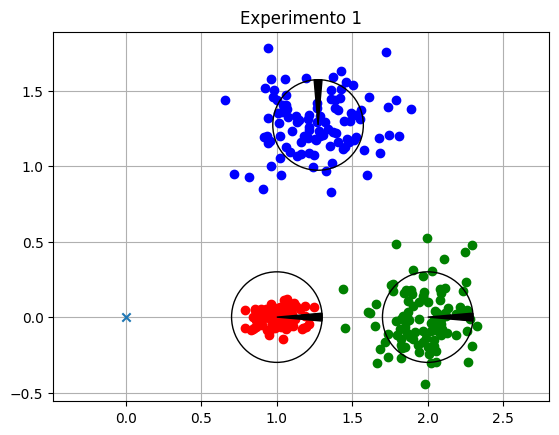

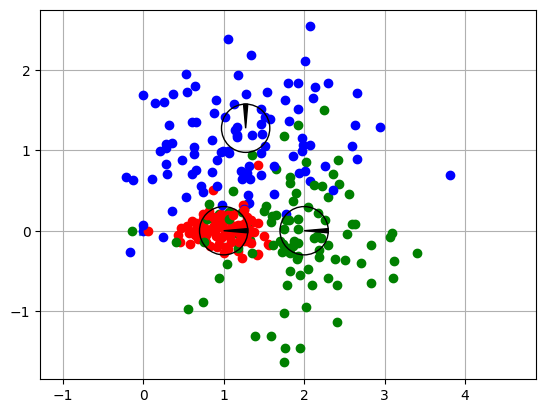

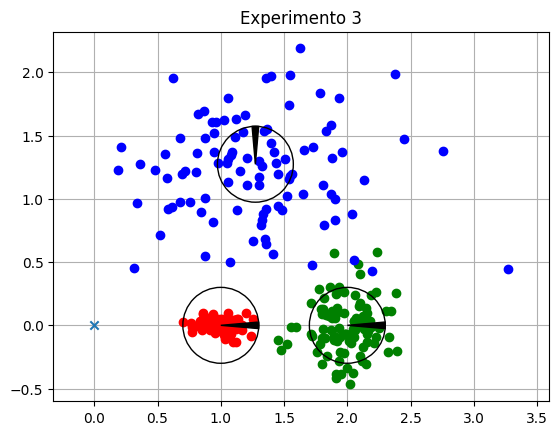

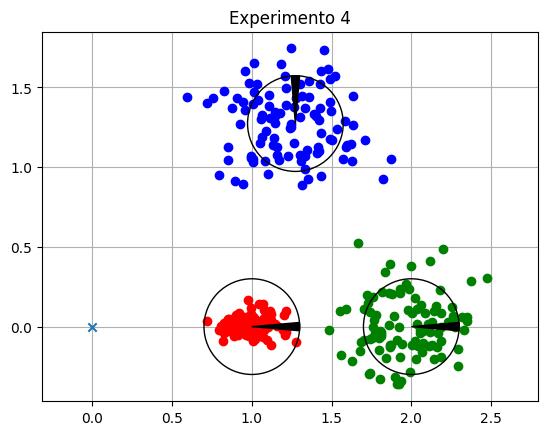

In [ ]:
u_t = np.array([[1, 2, 2],
                [0, 0, np.pi / 2]])

x_tp = np.array([[0, 0, 0],
                  [0, 0, 0],
                  [0, 0, 0]])

colors = {0: 'r', 1: 'g', 2: 'b'}

alpha_nominal = np.zeros(6)
nominal_model = MotionModelVelocity(alpha_nominal, n_samples=1, deltat=1)
nominal_positions = nominal_model.sample(x_tp=x_tp, u_t=u_t)
# theta = 0 -> caso problemático do modelo:
nominal_positions[0, 0] = 1
nominal_positions[0, 1] = 2

alpha_1 = np.ones(6) * 0.01
model_1 = MotionModelVelocity(alpha_1, n_samples=100, deltat=1)
samples_1 = model_1.sample(x_tp=x_tp, u_t=u_t)

alpha_2 = np.ones(6) * 0.1
model_2 = MotionModelVelocity(alpha_2, n_samples=100, deltat=1)
samples_2 = model_2.sample(x_tp=x_tp, u_t=u_t)

alpha_3 = np.ones(6) * 0.01
alpha_3[1], alpha_3[3], alpha_3[5] = 0.1, 0.1, 0.1
model_3 = MotionModelVelocity(alpha_3, n_samples=100, deltat=1)
samples_3 = model_3.sample(x_tp=x_tp, u_t=u_t)

alpha_4 = np.ones(6) * 0.01
alpha_3[0], alpha_3[2], alpha_3[4] = 0.1, 0.1, 0.1
model_4 = MotionModelVelocity(alpha_4, n_samples=100, deltat=1)
samples_4 = model_4.sample(x_tp=x_tp, u_t=u_t)


fig, ax = plt.subplots()
plt.grid()
plt.scatter(0, 0, marker='x')
for i in range(len(samples_1[0])):
    plt.scatter(*samples_1[:2, i], c=colors[i % 3])
plt.title("Experimento 1")
plot_robots(ax, nominal_positions)
plt.axis("equal")
ax.set_axisbelow(True)
plt.show()

fig, ax = plt.subplots()
plt.grid()
plt.scatter(0, 0, marker='x')
for i in range(300):
    plt.scatter(*samples_2[:2, i], c=colors[i % 3])
plot_robots(ax, nominal_positions)
plt.axis("equal")
ax.set_axisbelow(True)
plt.show()

fig, ax = plt.subplots()
plt.grid()
plt.scatter(0, 0, marker='x')
for i in range(300):
    plt.scatter(*samples_3[:2, i], c=colors[i % 3])
plt.title("Experimento 3")
plot_robots(ax, nominal_positions)
plt.axis("equal")
ax.set_axisbelow(True)
plt.show()

fig, ax = plt.subplots()
plt.grid()
plt.scatter(0, 0, marker='x')
for i in range(300):
    plt.scatter(*samples_4[:2, i], c=colors[i % 3])
plt.title("Experimento 4")
plot_robots(ax, nominal_positions)
plt.axis("equal")
ax.set_axisbelow(True)
plt.show()

### Teste da função *motion_model_velocity*

Para análise da função *motion_model_velocity* a likelihood foi utilizada para fazer um mapa de calor implementado no código a seguir gerando a figura em sequência.

A função *MotionModelVelocity.get_probs* itera sobre todos as amostras do $ x_{t-1}$ realiza o cálculo da likelihood com uso da função *MotionModelVelocity.motion_model_velocity* somando-as e, finalmente, as normaliza de maneira a obter uma probabilidade associada a cada uma das amostras geradas para o estado $ x_{t}$, em considerando o $ u_t $.

Com esta função codificada dentro da classe que implementa o modelo, o código a seguir a utiliza para um robô partindo da origem, com $ \theta = 0 $ e velocidade linear $ v= 2 m/s $ e $ w = 0 \ rad/s $. O tempo de amostragem do modelo é novamente $ \Delta t = 1 s $. São observadas duas iteração de comandos iguais. Os parâmetros $ \alpha = \{0.001, 0.001, 0.01, 0.01, 0.01, 0.01\} $ de maneira que o há maior variância associada aos movimentos angulares. Para cada estado amostrados são realizadas 100 novas amostras no tempo seguinte. Assim, para os tempos $ t = 0, 1 $ e $ 2 $ respectivamente existe $1, 100$ e $10000$ amostras.

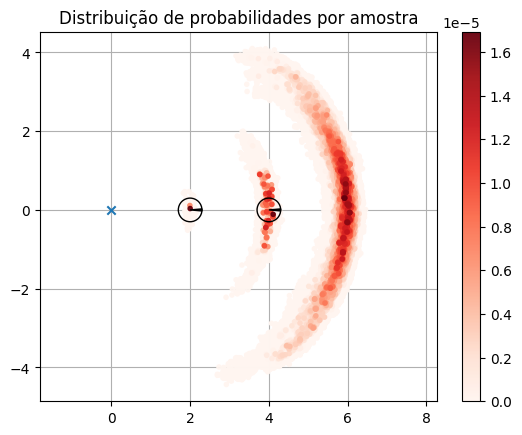

In [ ]:
u_t = np.array([[2],
                [0]])

x_0 = np.array([[0],
                [0],
                [0]])

colors = {0: 'r', 1: 'g', 2: 'b'}

alpha_mult = np.ones(6)
alpha_mult[0], alpha_mult[1] = 0.001, 0.001
alpha_mult[2], alpha_mult[3] = 0.01, 0.01
alpha_mult[4], alpha_mult[5] = 0.01, 0.01

model_mult = MotionModelVelocity(alpha_mult, n_samples=100, deltat=1)
nominal_position = np.array([[2, 4], #, 6],
                              [0, 0], #, 0],
                              [0, 0]]) #, 0]])

x_1 = model_mult.sample(x_tp=x_0, u_t=u_t)
lkhd_1 = model_mult.get_probs(x_tp=x_0, u_t=u_t, x_t=x_1)
x1_aug = np.vstack((x_1, lkhd_1))
x1_aug = x1_aug[:, x1_aug[3, :].argsort()]

x_2 = model_mult.sample(x_tp=x_1, u_t=u_t)
lkhd_2 = model_mult.get_probs(x_tp=x_1, u_t=u_t, x_t=x_2)
x2_aug = np.vstack((x_2, lkhd_2))
x2_aug = x2_aug[:, x2_aug[3, :].argsort()]

x_3 = model_mult.sample(x_tp=x_2, u_t=u_t)
lkhd_3 = model_mult.get_probs(x_tp=x_2, u_t=u_t, x_t=x_3)
x3_aug = np.vstack((x_3, lkhd_3))
x3_aug = x3_aug[:, x3_aug[3, :].argsort()]

fig, ax = plt.subplots()
plt.scatter(0, 0, marker='x')
plt.grid()
plt.scatter(x=x1_aug[0, :], y=x1_aug[1, :], c=x1_aug[3, :], marker='.', cmap='Reds', alpha=0.95)
plt.scatter(x=x2_aug[0, :], y=x2_aug[1, :], c=x2_aug[3, :], marker='.', cmap='Reds', alpha=0.95)
plt.scatter(x=x3_aug[0, :], y=x3_aug[1, :], c=x3_aug[3, :], marker='.', cmap='Reds', alpha=0.95)
plot_robots(ax, poses=nominal_position)
ax.set_axisbelow(True)
plt.axis("equal")
plt.colorbar()
plt.title("Distribuição de probabilidades por amostra")
plt.show()


Neste gráfico também foram apresentadas a poses nominais esperadas para o robo estudado nos dois tempos, representadas em preto. Qualitativamente, observa-se que tanto a função de amostragem quanto a de likelihood aparentam resultados coerentes de maneira que as distribuições paresentam características esperadas em termos de distribuição espacial e concentração da densidade de probabilidade no entorno do modelo nominal de evolução do problelma.  

### Funções de modelagem considerando a Odometria

O modelo de movimentação por odometria consiste na utilização das medições do odômetro como sinal de controle, pressupondo que estas foram os comandos utilizados para movimentar o robô entre dois pontos: com base nas medições  $\bar{x}_{t-1}$ e $\bar{x}_t$ do odômetro, a odometria relativa entre $x_{t-1}$ e $x_t$ é calculada a partir da obtenção de uma sequência de 3 passos: uma rotação inicial, ($\delta_{rot1}$) seguida de uma translação ($\delta_{trans}$) e uma rotação final ($\delta_{rot2}$).

Como os sensores do odômetro possuem imperfeições, a pose final do robô é calculada como uma função de probabilidade $p(x_t | u_t, x_{t-1})$, calculada a partir de duas funções:







O modelo é composto por duas funções principais, denominadas $\textbf{sample_motion_model_odometry}$ e $\textbf{algorithm_motion_model_odometry}$: a primeira é algoritmo de sampling de $p(x_t | u_t, x_{t-1})$, utilizada quando filtro de partículas são utilizados para a localização.



que recebe como principais parâmetros de entrada:

* os $\textit{beliefs}$ inicial e final do robô ($x_{t-1}$ e $x_t$, respectivamente);

* as poses $\bar{x}_{t-1}$ e $\bar{x}_t$ obtidas pelo odômetro;

* o vetor contendo os coefientes $\alpha_1$ a $\alpha_6$, que modelam a imprecisão dos sensores


In [ ]:

def algorithm_sample_normal_distribution(variance):
  variance = abs(variance)
  return 0.5*np.random.uniform(-variance, variance, 12).sum()


def plot_robo(pose, radius):
    span = np.linspace(0, 2*pi, 360)

    for i in range(shape(pose)[1]):
        a = radius*cos(span) + pose[0,i]
        b = radius*sin(span) + pose[1,i]
        plt.plot(a,b, 'black')
        plt.grid(True)

        endx = pose[0,i] + radius * math.cos(pose[2,i])
        endy = pose[1,i] + radius * math.sin(pose[2,i])
        plt.plot([pose[0,i], endx], [pose[1,i], endy], 'black')


def plot_mm_odometry(odometry, delta_rot1, delta_rot2, radius):

    plot_robo(odometry, 0.2)

    if delta_rot1 >0:
        arc1 = Arc((odometry[0,0], odometry[1,0]), radius, radius, 0, np.degrees(odometry[2,0]), np.degrees(odometry[2,0]+delta_rot1), color='black')
    else:
        arc1 = Arc((odometry[0,0], odometry[1,0]), radius, radius, 0, np.degrees(odometry[2,0]+delta_rot1), np.degrees(odometry[2,0]), color= 'black')

    plt.plot(odometry[0,0:2], odometry[1,0:2], 'black') # deslocamento entre poses

    endx = odometry[0,1] + radius * math.cos(delta_rot1 + odometry[2,0])
    endy = odometry[1,1] + radius * math.sin(delta_rot1 + odometry[2,0])
    plt.plot([odometry[0,1], endx], [odometry[1,1], endy], 'black')

    if delta_rot2 >0:
        arc2 = Arc((odometry[0,1], odometry[1,1]), radius, radius, 0, np.degrees(odometry[2,0] + delta_rot1), np.degrees(odometry[2,1]), color='black')
    else:
        arc2 = Arc((odometry[0,1], odometry[1,1]), radius, radius, 0, np.degrees(odometry[2,1]), np.degrees(odometry[2,0] + delta_rot1), color= 'black')

    ax = plt.gca()
    ax.add_patch(arc1)
    ax.add_patch(arc2)


def sample_motion_model_odometry(odometry, prior_pose, alphas, n_it, print):
    delta_odometry = odometry[:,1] - odometry[:,0]

    delta_rot1 = arctan2(delta_odometry[1], delta_odometry[0]) - odometry[2,0]
    delta_trans = sqrt(delta_odometry[0]**2 + delta_odometry[1]**2)
    delta_rot2 = delta_odometry[2] - delta_rot1

    pose_prime = array([[],[],[]])

    for i in range(shape(prior_pose)[1]):
        for j in range(n_it):
            delta_rot1_hat = delta_rot1 - algorithm_sample_normal_distribution(alphas[0]*delta_rot1 + alphas[1]*delta_trans)
            delta_trans_hat = delta_trans - algorithm_sample_normal_distribution(alphas[2]*delta_trans + alphas[3]*(delta_rot1 + delta_rot2))
            delta_rot2_hat = delta_rot2 - algorithm_sample_normal_distribution(alphas[4]*delta_rot2 + alphas[5]*delta_trans)

            x_prime = prior_pose[0,i] + delta_trans_hat*cos(prior_pose[2,i] + delta_rot1_hat)
            y_prime = prior_pose[1,i] + delta_trans_hat*sin(prior_pose[2,i] + delta_rot1_hat)
            theta_prime = prior_pose[2,i] + delta_rot1_hat + delta_rot2_hat

            pose_prime = np.hstack((pose_prime, array([[x_prime], [y_prime], [theta_prime]])))

    if print==1:
        plot_mm_odometry(odometry, delta_rot1, delta_rot2, 0.2)
        plt.scatter(pose_prime[0,:], pose_prime[1,:], marker='.')

    return pose_prime

<ipython-input-8-10f810fdc551>:25: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  arc1 = Arc((odometry[0,0], odometry[1,0]), radius, radius, 0, np.degrees(odometry[2,0]), np.degrees(odometry[2,0]+delta_rot1), color='black')
<ipython-input-8-10f810fdc551>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  arc2 = Arc((odometry[0,1], odometry[1,1]), radius, radius, 0, np.degrees(odometry[2,1]), np.degrees(odometry[2,0] + delta_rot1), color= 'black')
<ipython-input-8-10f810fdc551>:27: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  arc1 = Arc((odometry[0,0], odometry[1,0]), r

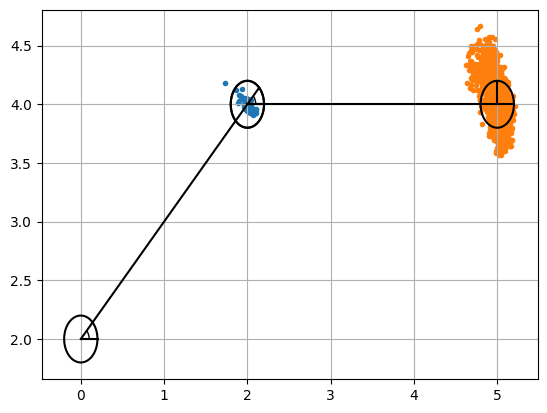

In [ ]:
odometry_0 =  array([[0], [2], [0]])
odometry_1 =  array([[2], [4], [0]])
odometry_2 = array([[5], [4], [pi/2]]) # maior índice: actual pose

odometry = np.hstack((odometry_0, odometry_1, odometry_2))

prior_pose = array([[0],[2],[0]])

alphas1 = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01] # alpha_1 a alpha_6

for i in range(shape(odometry)[1]-1):
    saida = sample_motion_model_odometry(odometry[:,i:i+2], prior_pose, alphas1, 50, 1)
    prior_pose = saida

## Odometria (closed form)

In [ ]:
def algorithm_prob_normal_distribution(sample, variance):
  p = np.exp(-.5 * sample ** 2 / variance)/ sqrt(2*pi*variance)
  return p


def algorithm_motion_model_odometry(odometry, final_hyp, prior_hyp, alphas):

  delta_odometry = odometry[:,1] - odometry[:,0]

  delta_rot1 = arctan2(delta_odometry[1], delta_odometry[0]) - odometry[2,0]
  delta_trans = sqrt(delta_odometry[0]**2 + delta_odometry[1]**2)
  delta_rot2 = delta_odometry[2] - delta_rot1

  likelihood = np.zeros([shape(prior_hyp)[1], shape(final_hyp)[1]])

  for i in range(shape(prior_hyp)[1]):
    for j in range(shape(final_hyp)[1]):
      delta_hyp = final_hyp[:,j] - prior_hyp[:,i]

      delta_rot1_hat = arctan2(delta_hyp[1], delta_hyp[0]) - prior_hyp[2,i]
      delta_trans_hat = sqrt(delta_hyp[0]**2 + delta_hyp[1]**2)
      delta_rot2_hat = delta_hyp[2] - delta_rot1_hat

      p1 = algorithm_prob_normal_distribution(delta_rot1 - delta_rot1_hat, alphas[0]*abs(delta_rot1) + alphas[1]*abs(delta_trans))
      p2 = algorithm_prob_normal_distribution(delta_trans - delta_trans_hat, alphas[2]*abs(delta_trans) + alphas[3]*(abs(delta_rot1) + abs(delta_rot2)))
      p3 = algorithm_prob_normal_distribution(delta_rot2 - delta_rot2_hat, alphas[4]*abs(delta_rot2) + alphas[5]*abs(delta_trans))

      likelihood[i,j] = p1*p2*p3

  likelihood = sum(likelihood)

  plot_mm_odometry(odometry, delta_rot1, delta_rot2,  0.2)
  prob =  likelihood*(1/likelihood.sum())
  plt.scatter(x=final_hyp[0, :], y=final_hyp[1, :], c=prob, marker='.', cmap='Reds', alpha=0.95)

  return likelihood

<ipython-input-8-10f810fdc551>:25: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  arc1 = Arc((odometry[0,0], odometry[1,0]), radius, radius, 0, np.degrees(odometry[2,0]), np.degrees(odometry[2,0]+delta_rot1), color='black')
<ipython-input-8-10f810fdc551>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  arc2 = Arc((odometry[0,1], odometry[1,1]), radius, radius, 0, np.degrees(odometry[2,1]), np.degrees(odometry[2,0] + delta_rot1), color= 'black')
<ipython-input-8-10f810fdc551>:27: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  arc1 = Arc((odometry[0,0], odometry[1,0]), r

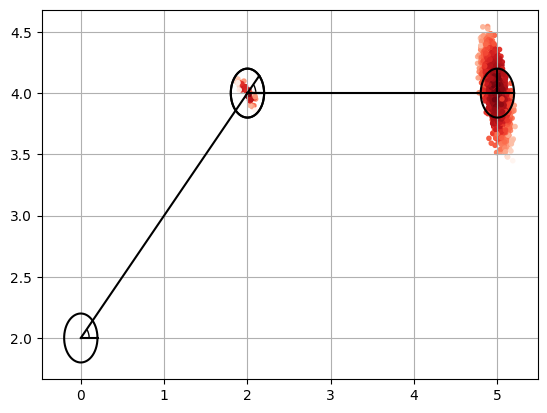

In [ ]:
odometry_0 =  array([[0], [2], [0]])
odometry_1 =  array([[2], [4], [0]])
odometry_2 = array([[5], [4], [pi/2]]) # maior índice: actual pose

odometry = np.hstack((odometry_0, odometry_1, odometry_2))
prior_pose = array([[0],[2],[0]])

alphas1 = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01] # alpha_1 a alpha_6
alphas2 = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01] # alpha_1 a alpha_6

for i in range(shape(odometry)[1]-1):
    saida = sample_motion_model_odometry(odometry[:,i:i+2], prior_pose, alphas1, 50, 0)
    likelihood = algorithm_motion_model_odometry(odometry[:,i:i+2], saida, prior_pose, alphas2)
    prior_pose = saida